Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!unzip '/content/drive/My Drive/Colab Notebooks/CNN_assignment.zip' -d '/content/drive/My Drive/Colab Notebooks/CNN_assigment'

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/CNN_assignment.zip
replace /content/drive/My Drive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
print(os.path.exists(data_dir_train))

True


In [ ]:
print(os.path.exists(data_dir_test))

True


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

seed=123

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the data will be used for validation
    seed=seed,
    shuffle=True,
    subset='training'  #  'training' for the training dataset
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
seed=123
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the data will be used for validation
    seed=seed,
    shuffle=True,
    subset='validation'  #  'validation' for the validation dataset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

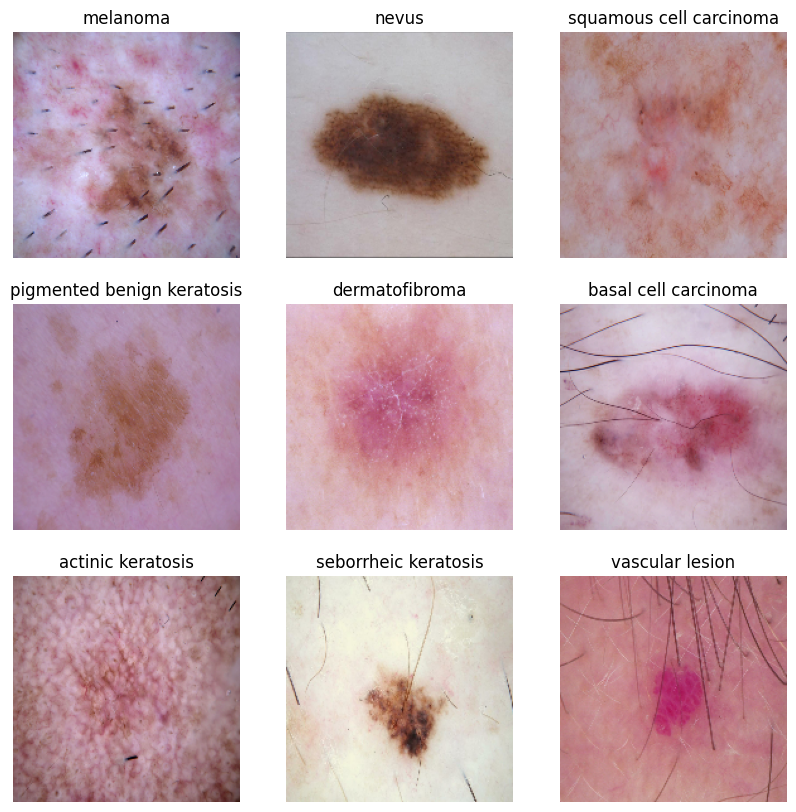

In [ ]:
import matplotlib.pyplot as plt
import random

# Define the number of classes you want to visualize
num_classes_to_visualize = 9

# Create a figure with a grid layout for visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Randomly shuffle the validation dataset
val_ds_shuffled = val_ds.unbatch().shuffle(buffer_size=1000).batch(1)

# Keep track of the classes that have been visualized
visualized_classes = set()

for img, label in val_ds_shuffled:
    class_idx=label.numpy()[0]
    if class_idx not in visualized_classes:
        ax = axes[len(visualized_classes) // 3, len(visualized_classes) % 3]
        ax.imshow(img[0].numpy().astype("uint8"))
        ax.set_title(class_names[class_idx])
        ax.axis('off')
        visualized_classes.add(class_idx)

    if len(visualized_classes) == num_classes_to_visualize:
        break

plt.show()






### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes=len(class_names)
def one_hot_encode(label):
    label = tf.dtypes.cast(label, tf.int32)
    return tf.one_hot(label, depth=num_classes)

# one-hot encoding to the labels in the dataset
train_ds = train_ds.map(lambda image, label: (image, one_hot_encode(label)))
val_ds = val_ds.map(lambda image, label: (image, one_hot_encode(label)))

In [ ]:
for img,label in train_ds:
  print(label)

tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(32, 9), dtype=float3

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
num_classes=len(class_names)
model=Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 activation (Activation)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                        

In [ ]:
sample_labels = next(iter(train_ds.map(lambda image, label: label).batch(1)))

# Print the sample labels to check their format
print(sample_labels)

tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0

### Train the model

In [ ]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 181s 3s/step - loss: 0.1467 - accuracy: 0.9342 - val_loss: 1.8584 - val_accuracy: 0.5638
Epoch 2/20
56/56 [==============================] - 172s 3s/step - loss: 0.1362 - accuracy: 0.9381 - val_loss: 1.8914 - val_accuracy: 0.5615
Epoch 3/20
56/56 [==============================] - 191s 3s/step - loss: 0.1464 - accuracy: 0.9314 - val_loss: 1.9160 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 177s 3s/step - loss: 0.1488 - accuracy: 0.9319 - val_loss: 1.8391 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 179s 3s/step - loss: 0.1361 - accuracy: 0.9403 - val_loss: 2.1528 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 185s 3s/step - loss: 0.1454 - accuracy: 0.9397 - val_loss: 2.0810 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 181s 3s/step - loss: 0.1355 - accuracy: 0.9414 - val_loss: 2.1175 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualizing training results

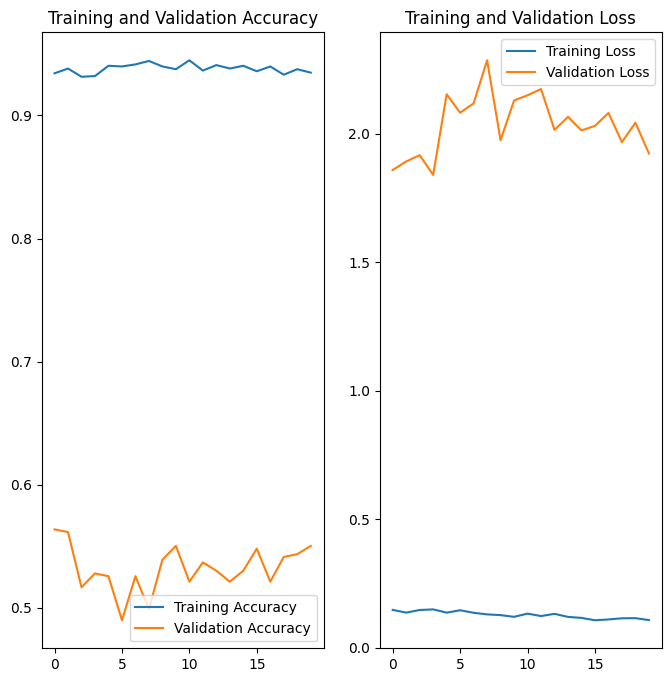

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
#1) the training accuracy is good (0.92), however the validation accuracy is low at 0.52
#2) There is no significant increase in validation accuracy beyong 3-4 epochs and the validation loss remains nearly the same across 20 epochs
# 2) maybe adding a dropout or including batch normalization might help reduce the gap between the two accuracies. Changing the no.of epochs can also be considered

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model=Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 53ms/step - loss: 0.3056 - accuracy: 0.8895 - val_loss: 3.1416 - val_accuracy: 0.4698
Epoch 2/30
56/56 [==============================] - 3s 50ms/step - loss: 0.2152 - accuracy: 0.9068 - val_loss: 3.0350 - val_accuracy: 0.4966
Epoch 3/30
56/56 [==============================] - 3s 46ms/step - loss: 0.1945 - accuracy: 0.9185 - val_loss: 3.4362 - val_accuracy: 0.4564
Epoch 4/30
56/56 [==============================] - 3s 45ms/step - loss: 0.1789 - accuracy: 0.9224 - val_loss: 3.0435 - val_accuracy: 0.4922
Epoch 5/30
56/56 [==============================] - 3s 46ms/step - loss: 0.1603 - accuracy: 0.9297 - val_loss: 3.4187 - val_accuracy: 0.4720
Epoch 6/30
56/56 [==============================] - 3s 48ms/step - loss: 0.1558 - accuracy: 0.9291 - val_loss: 3.4322 - val_accuracy: 0.4832
Epoch 7/30
56/56 [==============================] - 3s 48ms/step - loss: 0.1249 - accuracy: 0.9436 - val_loss: 3.0963 - val_accuracy: 0.4989
Epoch 8/30
56

### Visualizing the results

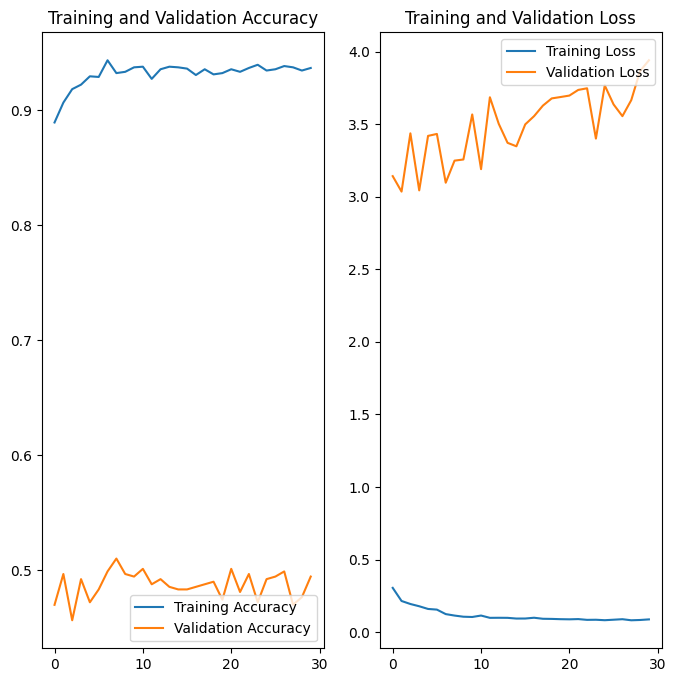

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#The validation accuracy has reduced, with adding more layers and increase in no.of epochs. There is marginal improvement in training accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
class_counts = {}

# Define a mapping from class index to class name
class_names_map = {
    0: 'actinic keratosis',
    1: 'basal cell carcinoma',
    2: 'dermatofibroma',
    3: 'melanoma',
    4: 'nevus',
    5: 'pigmented benign keratosis',
    6: 'seborrheic keratosis',
    7: 'squamous cell carcinoma',
    8: 'vascular lesion'
}

# Iterate through the training dataset
for images, labels in train_ds:
    # Convert the labels to numpy arrays
    labels = np.array(labels)

    # Find the index of the class with a '1' in the one-hot encoded label
    class_index = np.argmax(labels)

    # Get the class name based on the index
    class_name = class_names_map.get(class_index, 'Unknown')

    # Update the count for the class
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1

# Print the class distribution including class names
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")







nevus: 10 samples
vascular lesion: 3 samples
melanoma: 12 samples
actinic keratosis: 2 samples
basal cell carcinoma: 12 samples
pigmented benign keratosis: 8 samples
seborrheic keratosis: 3 samples
squamous cell carcinoma: 5 samples
dermatofibroma: 1 samples


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


1) Which class has the least number of samples?: dermatofibroma has just 1 sample

2)Which classes dominate the data in terms proportionate number of samples?: melanoma, basal cell carcinoma and nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
print(os.path.exists(path_to_training_dataset))


True


In [ ]:
import Augmentor
for i in class_names:
    class_directory = f"{path_to_training_dataset}/{i}"
    p = Augmentor.Pipeline(class_directory)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D317074CC10>: 100%|██████████| 500/500 [00:17<00:00, 29.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3171F027A0>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D3170DAA770>: 100%|██████████| 500/500 [00:17<00:00, 28.20 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D31707FBF40>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D315553BDC0>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D315556F370>: 100%|██████████| 500/500 [00:18<00:00, 27.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D31707D8130>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3170DA9F30>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D315553B040>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_6745f99a-c3cf-48b5-b1b3-2ca54c7ee653.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_876ef906-f497-4edf-8ef3-063c6d01b803.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_497ffdca-1c85-4073-b5c8-ece4d97ebdf2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_9c2c5e2d-cbdf-421e-98af-26cfb2bf8def.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin 

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

NameError: ignored

'original_df" dataframe was not created earlier, as there were no instructions regarding the same.

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/CNN_assigment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the data will be used for validation
    seed=123,
    shuffle=True,
    subset='training') #  'training' for the training dataset


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
seed=123
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the data will be used for validation
    seed=seed,
    shuffle=True,
    subset='validation'  #  'validation' for the validation dataset
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
num_classes=len(class_names)
def one_hot_encode(label):
    label = tf.dtypes.cast(label, tf.int32)
    return tf.one_hot(label, depth=num_classes)

# Apply one-hot encoding to the labels in the dataset
train_ds = train_ds.map(lambda image, label: (image, one_hot_encode(label)))
val_ds = val_ds.map(lambda image, label: (image, one_hot_encode(label)))

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

num_classes=len(class_names)
model=Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 51s 235ms/step - loss: 5.8254 - accuracy: 0.3377 - val_loss: 1.5851 - val_accuracy: 0.4336
Epoch 2/50
169/169 [==============================] - 37s 213ms/step - loss: 1.2618 - accuracy: 0.5410 - val_loss: 1.2683 - val_accuracy: 0.5583
Epoch 3/50
169/169 [==============================] - 40s 230ms/step - loss: 0.9624 - accuracy: 0.6660 - val_loss: 1.1057 - val_accuracy: 0.6184
Epoch 4/50
169/169 [==============================] - 40s 232ms/step - loss: 0.7565 - accuracy: 0.7507 - val_loss: 1.0223 - val_accuracy: 0.6414
Epoch 5/50
169/169 [==============================] - 40s 231ms/step - loss: 0.5654 - accuracy: 0.8201 - val_loss: 1.0151 - val_accuracy: 0.6644
Epoch 6/50
169/169 [==============================] - 35s 201ms/step - loss: 0.4378 - accuracy: 0.8633 - val_loss: 0.8777 - val_accuracy: 0.7127
Epoch 7/50
169/169 [==============================] - 40s 229ms/step - loss: 0.3610 - accuracy: 0.8846 - val_loss: 0.8412 - val_ac

#### **Todo:**  Visualize the model results

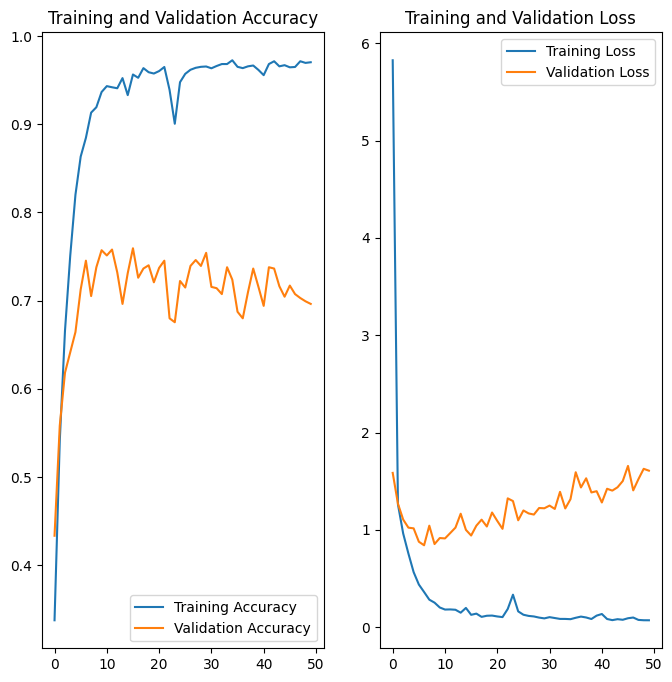

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



There is significant improvement in validation accuracy, after resolving the class imbalance problem. Maybe some more iterations can be performed with dropout or increase in no.of layers. However this may not be possible on google colab due to lack of GPU access, beyond a certain point

Modifying the CNN model with additional layers and dropout

In [ ]:
model=Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 235ms/step - loss: 1.9263 - accuracy: 0.2810 - val_loss: 1.7189 - val_accuracy: 0.3868
Epoch 2/30
169/169 [==============================] - 36s 208ms/step - loss: 1.5787 - accuracy: 0.3956 - val_loss: 1.4593 - val_accuracy: 0.4595
Epoch 3/30
169/169 [==============================] - 36s 209ms/step - loss: 1.4040 - accuracy: 0.4594 - val_loss: 1.4141 - val_accuracy: 0.4625
Epoch 4/30
169/169 [==============================] - 36s 209ms/step - loss: 1.2371 - accuracy: 0.5351 - val_loss: 1.1760 - val_accuracy: 0.5924
Epoch 5/30
169/169 [==============================] - 41s 236ms/step - loss: 1.0521 - accuracy: 0.6157 - val_loss: 1.0537 - val_accuracy: 0.6437
Epoch 6/30
169/169 [==============================] - 41s 235ms/step - loss: 0.8213 - accuracy: 0.7010 - val_loss: 0.8739 - val_accuracy: 0.7030
Epoch 7/30
169/169 [==============================] - 41s 235ms/step - loss: 0.6431 - accuracy: 0.7732 - val_loss: 0.9217 - val_ac

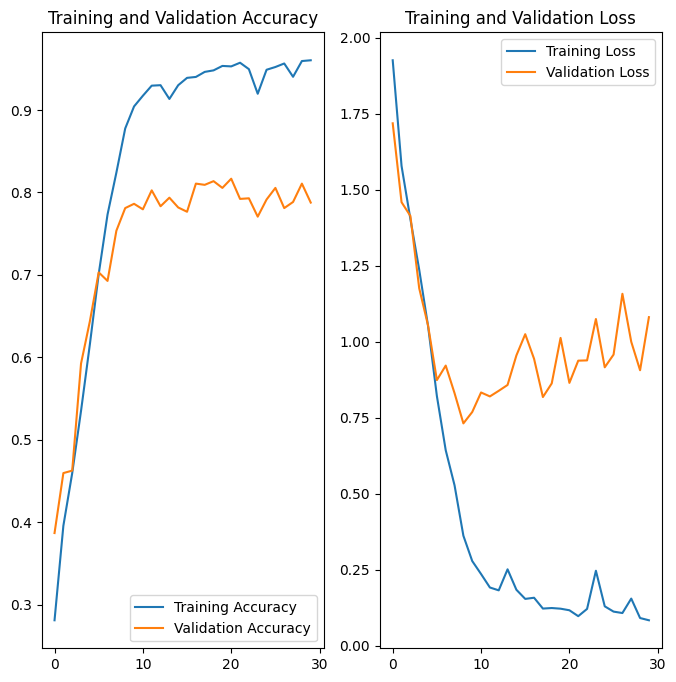

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Significant improvement in Validation accuracy (from 0.69-0.79), with addition of dropout